<a href="https://colab.research.google.com/github/halisson-gomides/IESB/blob/main/estatistica_analise_dados/trabalho_02/trabalho_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estatítica e Análise de Dados com Python

#### Alunos:
> Halisson Souza Gomides

> Ruy Pereira

> Rodrigo Taveira


# Trabalho 02
Neste trabalho, utilizaremos o dataset da aula passada: fraudes em cartões de crédito.

Note que o dataset é extremamente desbalanceado, com apenas cerca de 0.17% das transações sendo fraudulentas.

Para informações a respeito das colunas, consulte a referência no Kaggle apresentada no arquivo Reference.txt.

Sua tarefa consiste em realizar pelo menos as seguintes tarefas:

- Visualização do histograma de gastos geral do dataset (atente-se para uma escolha adequada do parâmetro bins);
- Visualização dos histogramas de gastos das transações fraudulentas e das transações não fraudulentas em separado (atente-se para uma escolha adequada do parâmetro bins);
- Para cada histograma gerado, indique, utilizando QQ-Plot, qual distribuição mais se adequa a ele e caracterize a distribuição (média e desvio padrão);
- Realize um teste A/B da seguinte forma: separe, aleatoriamente, dois grupos. O grupo A deve conter `50%` das transações não fraudulentas e `50%` das transações fraudulentas. O grupo B, por sua vez, deve conter os dados restantes. Por exemplo, se o dataset tivesse 100 transações (sendo 80 não fraudulentas e 20 fraudulentas), o grupo A teria 40 transações não fraudulentas e 10 transações fraudulentas (as mesmas quantidades se aplicariam ao grupo B). O grupo A deve ser o grupo de controle. O grupo B será o grupo que receberá a nova técnica de identificação de transações fraudulentas. Essa técnica consiste em: caso a transação possua um valor maior ou igual a `122.20`, ela deve ser classificada como fraudulenta. Avalie o desempenho dessa nova técnica sobre a porcentagem de transações fraudulentas do grupo A. Qual a porcentagem das transações que realmente eram fraudulentas realmente foram classificadas como fraudulentas? A técnica aplicada no grupo B é melhor do que a do grupo A?;
- Realize o seguinte teste de hipótese: transações fraudulentas possuem valores de gasto, na média, maiores ou iguais a 122.20; e
- Utilizando as classes LogisticRegression e SMOTE, realize oversampling e treine o modelo, relatando qual a porcentagem de transações fraudulentas detectadas.
> Observação: para esta última tarefa, não utilize `pd.get_dummies`, faça apenas `X = df['Amount']`.

Referência:
> https://github.com/LeonardoGoncRibeiro/PersonalProjects/blob/main/FraudDetection_OnlinePayments/FraudDetection_CreditCard.ipynb

## Ambiente

In [1]:
%%capture
!pip install -U matplotlib
!pip install -U imbalanced-learn
!pip install -U scipy

In [1]:
# Importando bibliotecas e setando parâmetros

import numpy as np
import pandas as pd
from scipy import stats
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Parâmetros iniciais

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)


sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

## Funções úteis

In [3]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df


def reduce_memory_usage(df: pd.DataFrame, datetime_features: List[str] = [], verbose=True):
    
  start_mem = df.memory_usage().sum() / 1024 ** 2
    
  df_optimized = optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

  end_mem = df.memory_usage().sum() / 1024 ** 2
  if verbose:
      print(
          "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
              end_mem, 100 * (start_mem - end_mem) / start_mem
          )
      )
  return df_optimized

In [4]:
# Funções gráficas

def grafico_quantidade(variavel, df, dict_de_para={}, paleta='jet_r', titulo='', tamanho=(10,5)):
  
  sns.set(rc={'figure.figsize':tamanho})
  
  if len(dict_de_para.keys()):

    xarr = df[variavel].values
    ticks_labels  = np.array(list(dict_de_para.keys()))
    ind = np.where(xarr.reshape(xarr.size, 1) == ticks_labels)[1]

    ax = sns.countplot(y=ind, data=df, palette=paleta)
    ax.set_yticks(range(len(np.unique(ind))))
    text_labels = np.vectorize(dict_de_para.get)(ticks_labels)
    ax.set_yticklabels(text_labels[:len(np.unique(ind))])
    
  else:
    ax = sns.countplot(y=variavel, data=df, palette=paleta)

  ax.set_xticklabels([])
  ax.set_xlabel('quantidade')

  # valores sobre o gráfico

  for container in ax.containers:
    ax.bar_label(container, fontsize=10, fmt = '%d')

  total = df.shape[0]
  for p in ax.patches:
      percentage = '{:.3f}%'.format(100 * p.get_width()/total)
      x = p.get_y() + p.get_width()
      y = p.get_y() + p.get_height() / 2 - 0.2
      ax.annotate(percentage, (x, y), size = 10)

  ax.patch.set_alpha(0.5)
  ax.set(title=titulo)
  return ax

In [5]:
def makeOverSamplesSMOTE(X,y):
 #input DataFrame
 #X →Independent Variable in DataFrame\
 #y →dependent Variable in Pandas DataFrame format
 from imblearn.over_sampling import SMOTE 
 sm = SMOTE(random_state=42)
 X, y = sm.fit_resample(X, y)
 return(X,y)

## Coleta dos dados

In [6]:
# Carregar os dados

file_path = '/content/drive/MyDrive/Colab Notebooks/IESB/Estatística e Análise de Dados com Python/Trabalho 02/dataset/creditcard.csv'
df_raw = pd.read_csv(file_path)
df_raw.columns = df_raw.columns.str.lower()
df_raw.head()

time     v1     v2    v3     v4     v5     v6     v7     v8     v9    v10  \
0 0.000 -1.360 -0.073 2.536  1.378 -0.338  0.462  0.240  0.099  0.364  0.091   
1 0.000  1.192  0.266 0.166  0.448  0.060 -0.082 -0.079  0.085 -0.255 -0.167   
2 1.000 -1.358 -1.340 1.773  0.380 -0.503  1.800  0.791  0.248 -1.515  0.208   
3 1.000 -0.966 -0.185 1.793 -0.863 -0.010  1.247  0.238  0.377 -1.387 -0.055   
4 2.000 -1.158  0.878 1.549  0.403 -0.407  0.096  0.593 -0.271  0.818  0.753   

     v11    v12    v13    v14    v15    v16    v17    v18    v19    v20  \
0 -0.552 -0.618 -0.991 -0.311  1.468 -0.470  0.208  0.026  0.404  0.251   
1  1.613  1.065  0.489 -0.144  0.636  0.464 -0.115 -0.183 -0.146 -0.069   
2  0.625  0.066  0.717 -0.166  2.346 -2.890  1.110 -0.121 -2.262  0.525   
3 -0.226  0.178  0.508 -0.288 -0.631 -1.060 -0.684  1.966 -1.233 -0.208   
4 -0.823  0.538  1.346 -1.120  0.175 -0.451 -0.237 -0.038  0.803  0.409   

     v21    v22    v23    v24    v25    v26    v27    v28  amount  class  
0 -0.018  0.278 -0.110  0.067  0.129 -0.189  0.134 -0.021 149.620      0  
1 -0.226 -0.639  0.101 -0.340  0.167  0.126 -0.009  0.015   2.690      0  
2  0.248  0.772  0.909 -0.689 -0.328 -0.139 -0.055 -0.060 378.660      0  
3 -0.108  0.005 -0.190 -1.176  0.647 -0.222  0.063  0.061 123.500      0  
4 -0.009  0.798 -0.137  0.141 -0.206  0.502  0.219  0.215  69.990      0

> CONTENT

- The dataset contains transactions made by credit cards in September 2013 by European cardholders.
- This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features `V1, V2, … V28` are the principal components obtained with PCA, the only features which have not been transformed with PCA are `'Time'` and `'Amount'`. Feature `'Time'` contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature `'Amount'` is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. - Feature `'Class'` is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [7]:
%%time
# Aplicando função para reduzir o uso de memória pelo dataframe

df = reduce_memory_usage(df_raw)

Mem. usage decreased to 32.87 Mb (51.2% reduction)
CPU times: user 504 ms, sys: 90.3 ms, total: 594 ms
Wall time: 609 ms


In [8]:
df.shape

(284807, 31)

## Limpeza e Transformação

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float32
 1   v1      284807 non-null  float32
 2   v2      284807 non-null  float32
 3   v3      284807 non-null  float32
 4   v4      284807 non-null  float32
 5   v5      284807 non-null  float32
 6   v6      284807 non-null  float32
 7   v7      284807 non-null  float32
 8   v8      284807 non-null  float32
 9   v9      284807 non-null  float32
 10  v10     284807 non-null  float32
 11  v11     284807 non-null  float32
 12  v12     284807 non-null  float32
 13  v13     284807 non-null  float32
 14  v14     284807 non-null  float32
 15  v15     284807 non-null  float32
 16  v16     284807 non-null  float32
 17  v17     284807 non-null  float32
 18  v18     284807 non-null  float32
 19  v19     284807 non-null  float32
 20  v20     284807 non-null  float32
 21  v21     28

*Nota: a princípio não se vê necessidade de aplicar transformações*

In [10]:
# verifica a existência de valores ausentes
pd.concat([df.isnull().sum(), df.isnull().sum()/len(df)*100], axis=1).rename(columns={0:'Qtde nulos',1:'Pct(%)'})

Qtde nulos  Pct(%)
time             0   0.000
v1               0   0.000
v2               0   0.000
v3               0   0.000
v4               0   0.000
v5               0   0.000
v6               0   0.000
v7               0   0.000
v8               0   0.000
v9               0   0.000
v10              0   0.000
v11              0   0.000
v12              0   0.000
v13              0   0.000
v14              0   0.000
v15              0   0.000
v16              0   0.000
v17              0   0.000
v18              0   0.000
v19              0   0.000
v20              0   0.000
v21              0   0.000
v22              0   0.000
v23              0   0.000
v24              0   0.000
v25              0   0.000
v26              0   0.000
v27              0   0.000
v28              0   0.000
amount           0   0.000
class            0   0.000

*Nota: não há valores ausentes no conjunto de dados, o que dispensa tratamento de valores ausentes.*

In [11]:
# Verificando a existência de observações duplicadas
df.duplicated().sum()

1081

In [12]:
df.loc[df.duplicated()]

time     v1     v2     v3     v4     v5     v6     v7    v8  \
33         26.000 -0.530  0.874  1.347  0.145  0.414  0.100  0.711 0.176   
35         26.000 -0.535  0.865  1.351  0.148  0.434  0.087  0.693 0.180   
113        74.000  1.038  0.127  0.184  1.110  0.442  0.945 -0.037 0.351   
114        74.000  1.038  0.127  0.184  1.110  0.442  0.945 -0.037 0.351   
115        74.000  1.038  0.127  0.184  1.110  0.442  0.945 -0.037 0.351   
...           ...    ...    ...    ...    ...    ...    ...    ...   ...   
282987 171288.000  1.913 -0.455 -1.751  0.454  2.089  4.160 -0.881 1.082   
283483 171627.000 -1.464  1.368  0.816 -0.601 -0.689 -0.487 -0.304 0.885   
283485 171627.000 -1.458  1.378  0.812 -0.604 -0.712 -0.472 -0.283 0.881   
284191 172233.000 -2.668  3.161 -3.356  1.008 -0.377 -0.110 -0.667 2.310   
284193 172233.000 -2.692  3.123 -3.339  1.017 -0.293 -0.167 -0.746 2.326   

           v9    v10    v11   v12    v13    v14    v15    v16    v17    v18  \
33     -0.287 -0.485  0.872 0.852 -0.572  0.101 -1.520 -0.284 -0.311 -0.404   
35     -0.286 -0.482  0.872 0.853 -0.572  0.102 -1.520 -0.286 -0.310 -0.404   
113     0.119 -0.243  0.578 0.675 -0.534  0.447  1.123 -1.768  1.241 -2.449   
114     0.119 -0.243  0.578 0.675 -0.534  0.447  1.123 -1.768  1.241 -2.449   
115     0.119 -0.243  0.578 0.675 -0.534  0.447  1.123 -1.768  1.241 -2.449   
...       ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
282987  1.023  0.005 -0.542 0.745 -0.375 -0.068 -0.796 -0.498 -0.134 -1.005   
283483  0.054 -0.828 -1.193 0.945  1.373 -0.036 -0.209  0.320 -0.205 -0.025   
283485  0.053 -0.831 -1.192 0.943  1.373 -0.038 -0.208  0.322 -0.206 -0.025   
284191 -1.639 -1.450 -0.509 0.600 -0.627  1.017 -0.887  0.420  1.856  1.315   
284193 -1.635 -1.440 -0.512 0.608 -0.628  1.023 -0.888  0.413  1.860  1.317   

          v19    v20    v21    v22    v23    v24    v25    v26    v27    v28  \
33     -0.823 -0.290  0.047  0.208 -0.186  0.001  0.099 -0.553 -0.073  0.023   
35     -0.824 -0.283  0.050  0.207 -0.187  0.001  0.098 -0.553 -0.078  0.025   
113    -1.747 -0.336  0.103  0.605  0.023 -0.626  0.479 -0.167  0.081  0.001   
114    -1.747 -0.336  0.103  0.605  0.023 -0.626  0.479 -0.167  0.081  0.001   
115    -1.747 -0.336  0.103  0.605  0.023 -0.626  0.479 -0.167  0.081  0.001   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
282987  0.086 -0.208 -0.524 -1.338  0.474  0.617 -0.284 -1.085  0.073 -0.036   
283483 -0.469  0.032  0.287  0.948 -0.219  0.083  0.044  0.639  0.214  0.119   
283485 -0.468  0.024  0.284  0.950 -0.217  0.083  0.045  0.640  0.219  0.117   
284191  1.096 -0.822  0.391  0.267 -0.080 -0.096  0.087 -0.451 -1.184 -0.222   
284193  1.095 -0.791  0.403  0.260 -0.087 -0.098  0.084 -0.454 -1.205 -0.213   

        amount  class  
33       6.140      0  
35       1.770      0  
113      1.180      0  
114      1.180      0  
115      1.180      0  
...        ...    ...  
282987  11.990      0  
283483   6.820      0  
283485  11.930      0  
284191  55.660      0  
284193  36.740      0  

[1081 rows x 31 columns]

*Nota: parece haver 1081 transações duplicadas. Contudo, como as variáveis `V1 a v28` são componentes principais decorrentes da aplicação de técnica de PCA, conforme descrito na contextualização acerca do conjunto de dados, não devemos rejeitá-las por não conhecer as features originais a que elas se relacionam. Assim, assumimos que esta situação é normal para esse caso específico em que as features são compomentes principais e manteremos os registros duplicados.*

In [13]:
# Agora, vamos ver se temos algum valor estranho nas features numéricas:
df.describe().T

count      mean       std      min       25%       50%        75%  \
time   284807.000 94813.867 47488.145    0.000 54201.500 84692.000 139320.500   
v1     284807.000     0.000     1.959  -56.408    -0.920     0.018      1.316   
v2     284807.000     0.000     1.651  -72.716    -0.599     0.065      0.804   
v3     284807.000    -0.000     1.516  -48.326    -0.890     0.180      1.027   
v4     284807.000     0.000     1.416   -5.683    -0.849    -0.020      0.743   
v5     284807.000     0.000     1.380 -113.743    -0.692    -0.054      0.612   
v6     284807.000    -0.000     1.332  -26.161    -0.768    -0.274      0.399   
v7     284807.000    -0.000     1.237  -43.557    -0.554     0.040      0.570   
v8     284807.000    -0.000     1.194  -73.217    -0.209     0.022      0.327   
v9     284807.000    -0.000     1.099  -13.434    -0.643    -0.051      0.597   
v10    284807.000    -0.000     1.089  -24.588    -0.535    -0.093      0.454   
v11    284807.000     0.000     1.021   -4.797    -0.762    -0.033      0.740   
v12    284807.000     0.000     0.999  -18.684    -0.406     0.140      0.618   
v13    284807.000     0.000     0.995   -5.792    -0.649    -0.014      0.663   
v14    284807.000    -0.000     0.959  -19.214    -0.426     0.051      0.493   
v15    284807.000    -0.000     0.915   -4.499    -0.583     0.048      0.649   
v16    284807.000     0.000     0.876  -14.130    -0.468     0.066      0.523   
v17    284807.000    -0.000     0.849  -25.163    -0.484    -0.066      0.400   
v18    284807.000     0.000     0.838   -9.499    -0.499    -0.004      0.501   
v19    284807.000     0.000     0.814   -7.214    -0.456     0.004      0.459   
v20    284807.000    -0.000     0.771  -54.498    -0.212    -0.062      0.133   
v21    284807.000    -0.000     0.735  -34.830    -0.228    -0.029      0.186   
v22    284807.000     0.000     0.726  -10.933    -0.542     0.007      0.529   
v23    284807.000     0.000     0.624  -44.808    -0.162    -0.011      0.148   
v24    284807.000     0.000     0.606   -2.837    -0.355     0.041      0.440   
v25    284807.000     0.000     0.521  -10.295    -0.317     0.017      0.351   
v26    284807.000     0.000     0.482   -2.605    -0.327    -0.052      0.241   
v27    284807.000     0.000     0.404  -22.566    -0.071     0.001      0.091   
v28    284807.000    -0.000     0.330  -15.430    -0.053     0.011      0.078   
amount 284807.000    88.350   250.120    0.000     5.600    22.000     77.165   
class  284807.000     0.002     0.042    0.000     0.000     0.000      0.000   

              max  
time   172792.000  
v1          2.455  
v2         22.058  
v3          9.383  
v4         16.875  
v5         34.802  
v6         73.302  
v7        120.589  
v8         20.007  
v9         15.595  
v10        23.745  
v11        12.019  
v12         7.848  
v13         7.127  
v14        10.527  
v15         8.878  
v16        17.315  
v17         9.254  
v18         5.041  
v19         5.592  
v20        39.421  
v21        27.203  
v22        10.503  
v23        22.528  
v24         4.585  
v25         7.520  
v26         3.517  
v27        31.612  
v28        33.848  
amount  25691.160  
class       1.000

## Análise Exploratório dos dados

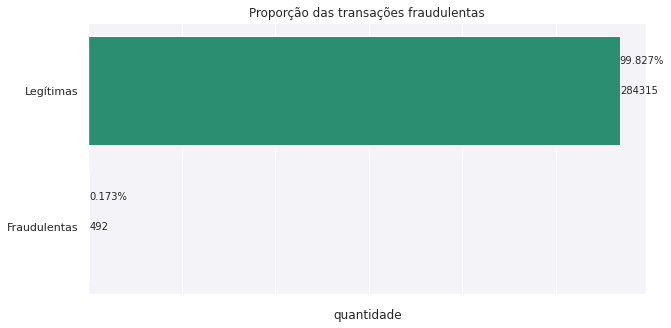

In [14]:
# Verificando a proporção de transações fraudulentas
class_dict = {
    0: 'Legítimas',
    1: 'Fraudulentas',}

grafico_quantidade(variavel='class', df=df, dict_de_para=class_dict, titulo='Proporção das transações fraudulentas', paleta='Dark2');

### Visualização do histograma de gastos geral do dataset 

In [15]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("ticks")
sns.despine(left=False, bottom=True);

<Figure size 864x432 with 0 Axes>

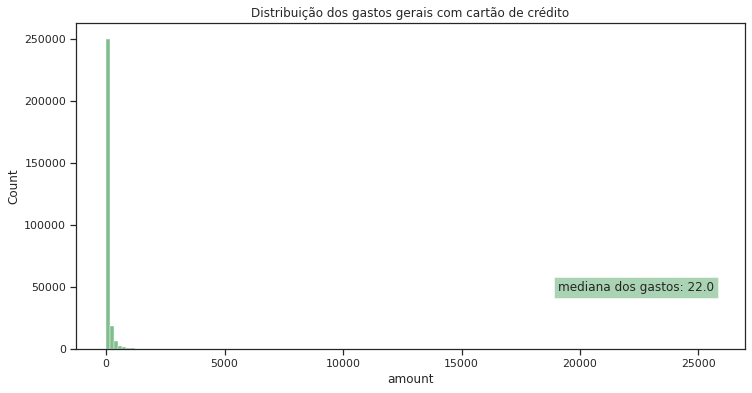

In [16]:
ax = sns.histplot(data=df, x='amount', color='g', bins=150)
ax.set(title='Distribuição dos gastos gerais com cartão de crédito')

ax.text(.72, 50000, 'mediana dos gastos: '+ str(df['amount'].median().round(2)), va='center', ha="left", 
        bbox=dict(facecolor="g",alpha=0.5),
        transform=ax.get_yaxis_transform());

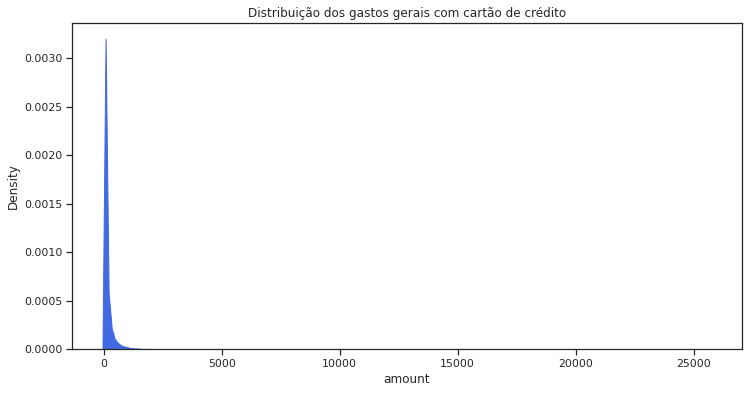

In [ ]:
sns.kdeplot(data=df, x='amount', alpha=1, fill=True, color='royalblue').set(title='Distribuição dos gastos gerais com cartão de crédito');

In [ ]:
import plotly.express as px
fig = px.histogram(df, x="amount")
fig.update_traces(xbins=dict( 
        start=0,
        end=200,
        size=1
    ))
fig.update_layout(width=900)
fig.show()

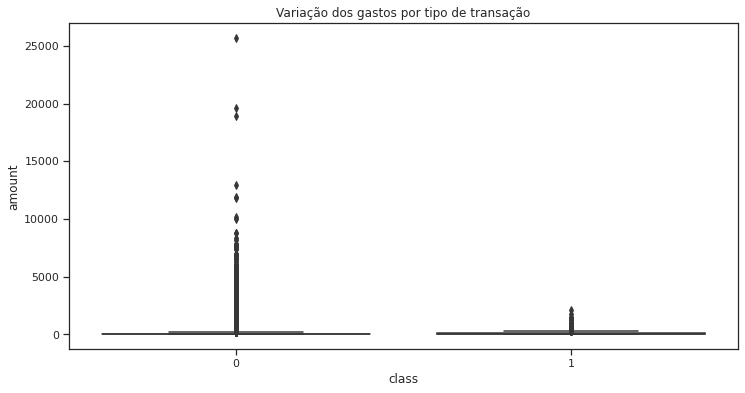

In [ ]:
sns.boxplot(data=df, x='class', y='amount', palette='Dark2').set(title='Variação dos gastos por tipo de transação');

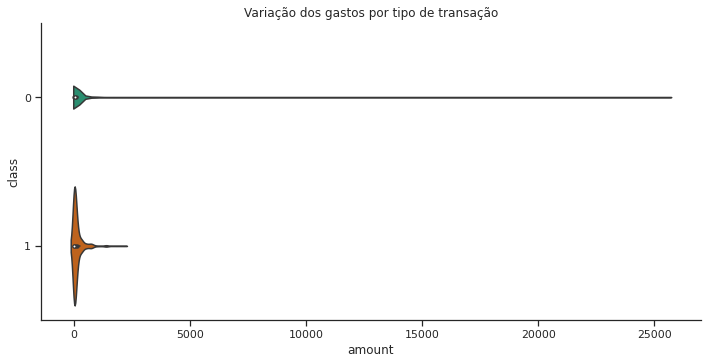

In [ ]:
sns.catplot(data=df, x='amount', y='class', kind='violin', height=5, aspect=2, palette='Dark2', orient='horizontal').set(title='Variação dos gastos por tipo de transação');



---


### Visualização dos histogramas de gastos das transações fraudulentas e das transações não fraudulentas em separado

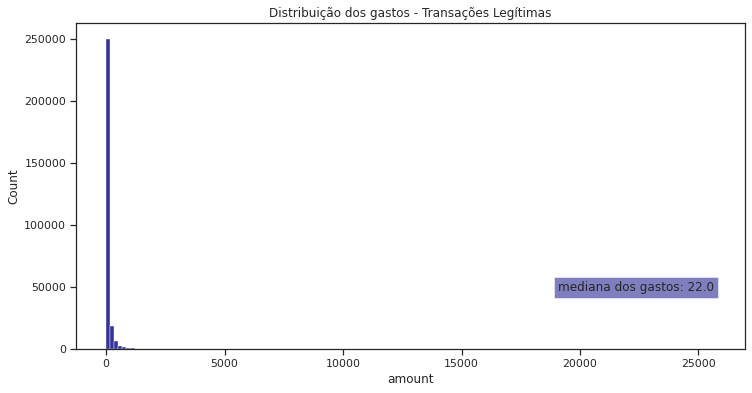

In [ ]:
ax = sns.histplot(data=df.loc[df['class']==0], x='amount', color='navy', alpha=0.8, bins=150)
ax.set(title='Distribuição dos gastos - Transações Legítimas')

ax.text(.72, 50000, 'mediana dos gastos: '+ str(df.loc[df['class']==0]['amount'].median().round(2)), va='center', ha="left", 
        bbox=dict(facecolor="navy",alpha=0.5),
        transform=ax.get_yaxis_transform());

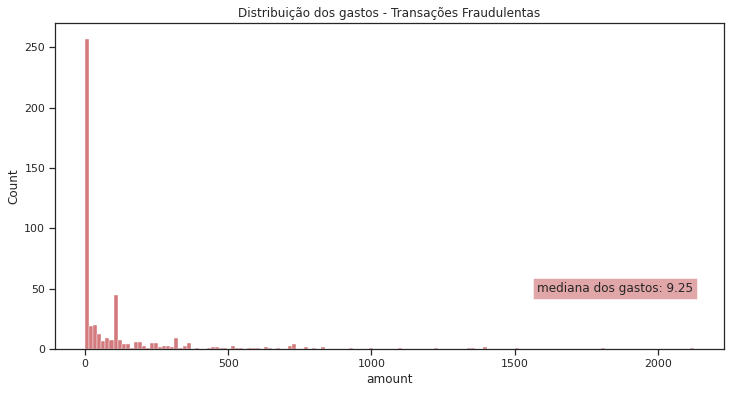

In [ ]:
ax = sns.histplot(data=df.loc[df['class']==1], x='amount', color='r', bins=150)
ax.set(title='Distribuição dos gastos - Transações Fraudulentas')

ax.text(.72, 50, 'mediana dos gastos: '+ str(df.loc[df['class']==1]['amount'].median().round(2)), va='center', ha="left", 
        bbox=dict(facecolor="r",alpha=0.5),
        transform=ax.get_yaxis_transform());



---


### Para cada histograma gerado, indique, utilizando QQ-Plot, qual distribuição mais se adequa a ele e caracterize a distribuição (média e desvio padrão);

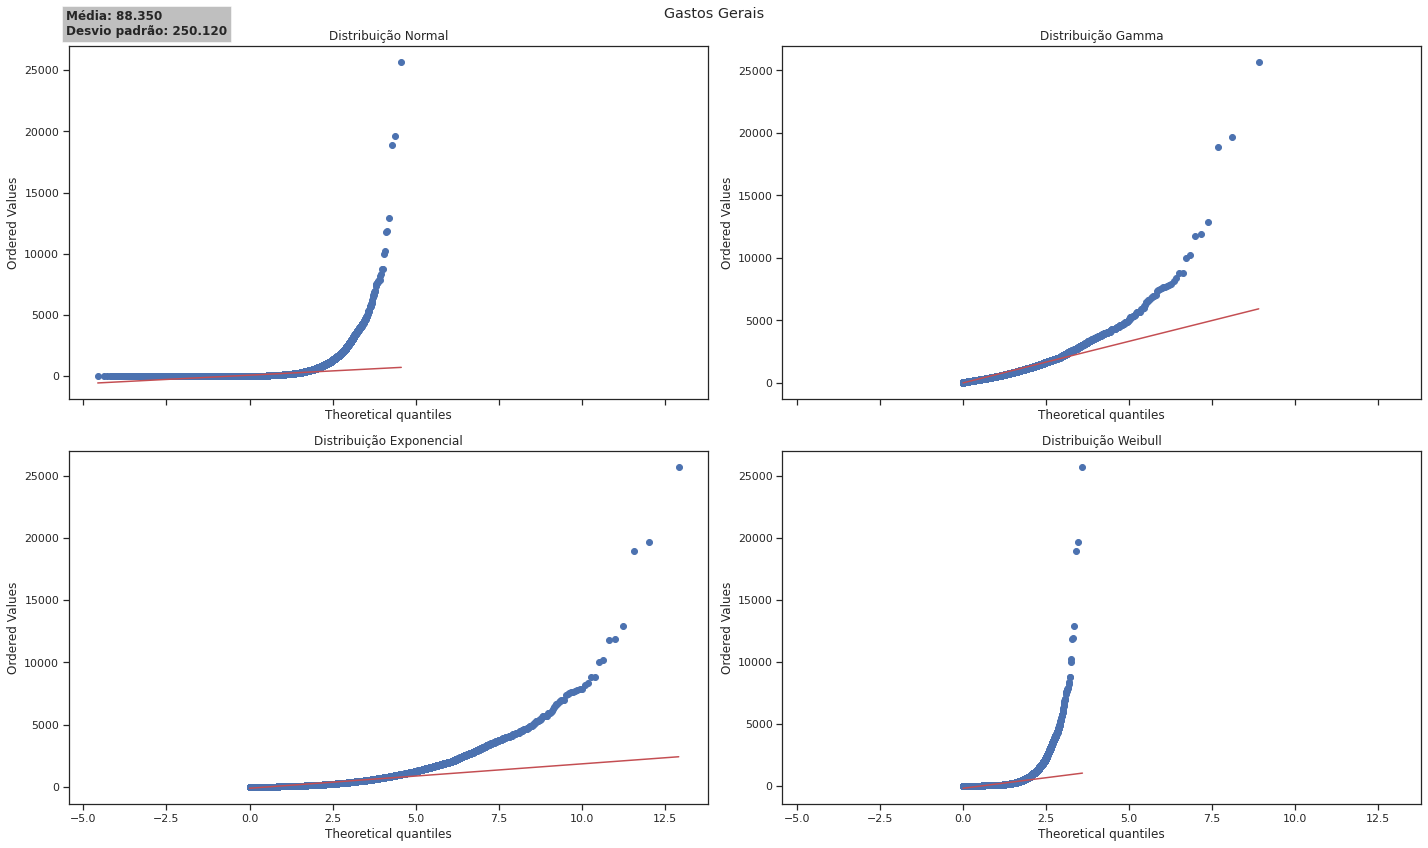

In [ ]:
# QQ-Plots Distribuições- Gastos Gerais

plt.rcParams["figure.figsize"]=(20,12)
fig, ax = plt.subplots(2,2, sharex=True)
dict_dists = {'Normal':stats.norm, 'Gamma':stats.gamma, 'Exponencial':stats.expon, 'Weibull':stats.weibull_min}
list_sparams = [None, (df['amount'].mean()**2 / df['amount'].var()), None, (2)]
axes = ax.flatten()

for ax, distribution, sparam in zip(axes, dict_dists, list_sparams):
  
  stats.probplot(df['amount'], dist=dict_dists[distribution], sparams=sparam, plot=ax)
  ax.set_title(f'Distribuição {distribution}')
  
fig.suptitle("Gastos Gerais")
fig.text(0.05, 0.96, f"Média: {df['amount'].mean():.3f} \nDesvio padrão: {df['amount'].std():.3f}", 
        va='center', ha="left", 
        fontdict=dict(weight='bold'),
        bbox=dict(facecolor="grey",alpha=0.5),
        transform=plt.gcf().transFigure);
fig.tight_layout()

*Nota:* pelos gráficos QQ-Plot acima, não é possível inferir a olho nu a que distribuição os gastos **gerais** mais se aproxima.

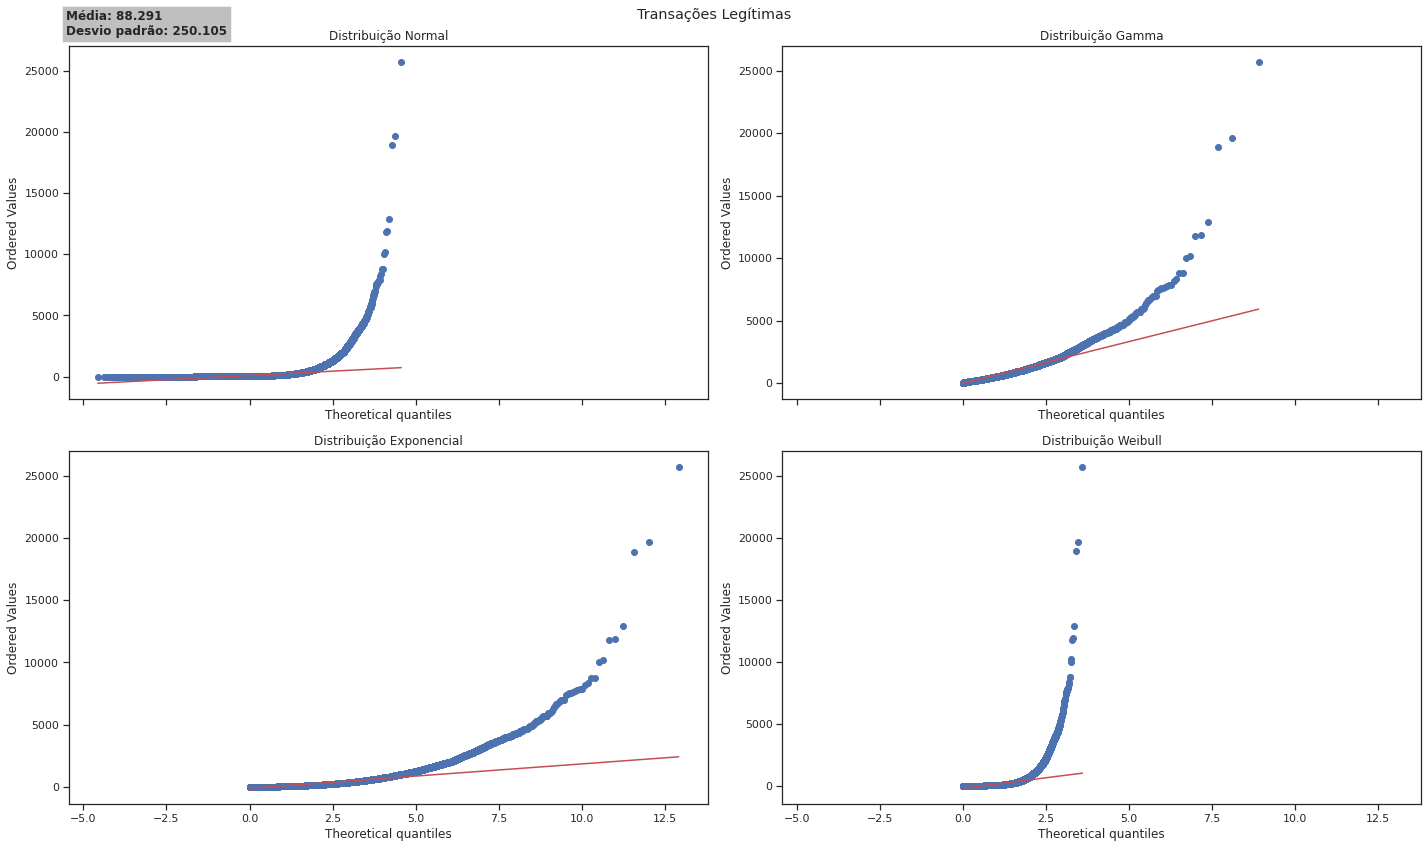

In [ ]:
# QQ-Plots Distribuições- Transações Legítimas

fig, ax = plt.subplots(2,2, sharex=True)
dict_dists = {'Normal':stats.norm, 'Gamma':stats.gamma, 'Exponencial':stats.expon, 'Weibull':stats.weibull_min}
list_sparams = [None, (df.loc[df['class']==0]['amount'].mean()**2 / df.loc[df['class']==0]['amount'].var()), None, (2)]
axes = ax.flatten()

for ax, distribution, sparam in zip(axes, dict_dists, list_sparams):
  
  stats.probplot(df.loc[df['class']==0]['amount'], dist=dict_dists[distribution], sparams=sparam, plot=ax)
  ax.set_title(f'Distribuição {distribution}')
  
fig.suptitle("Transações Legítimas")
fig.text(0.05, 0.96, f"Média: {df.loc[df['class']==0]['amount'].mean():.3f} \nDesvio padrão: {df.loc[df['class']==0]['amount'].std():.3f}", 
        va='center', ha="left", 
        fontdict=dict(weight='bold'),
        bbox=dict(facecolor="grey",alpha=0.5),
        transform=plt.gcf().transFigure);
fig.tight_layout()

*Nota:* pelos gráficos QQ-Plot acima, não é possível inferir a olho nu a que distribuição os gastos de transações **legítimas** mais se aproxima.

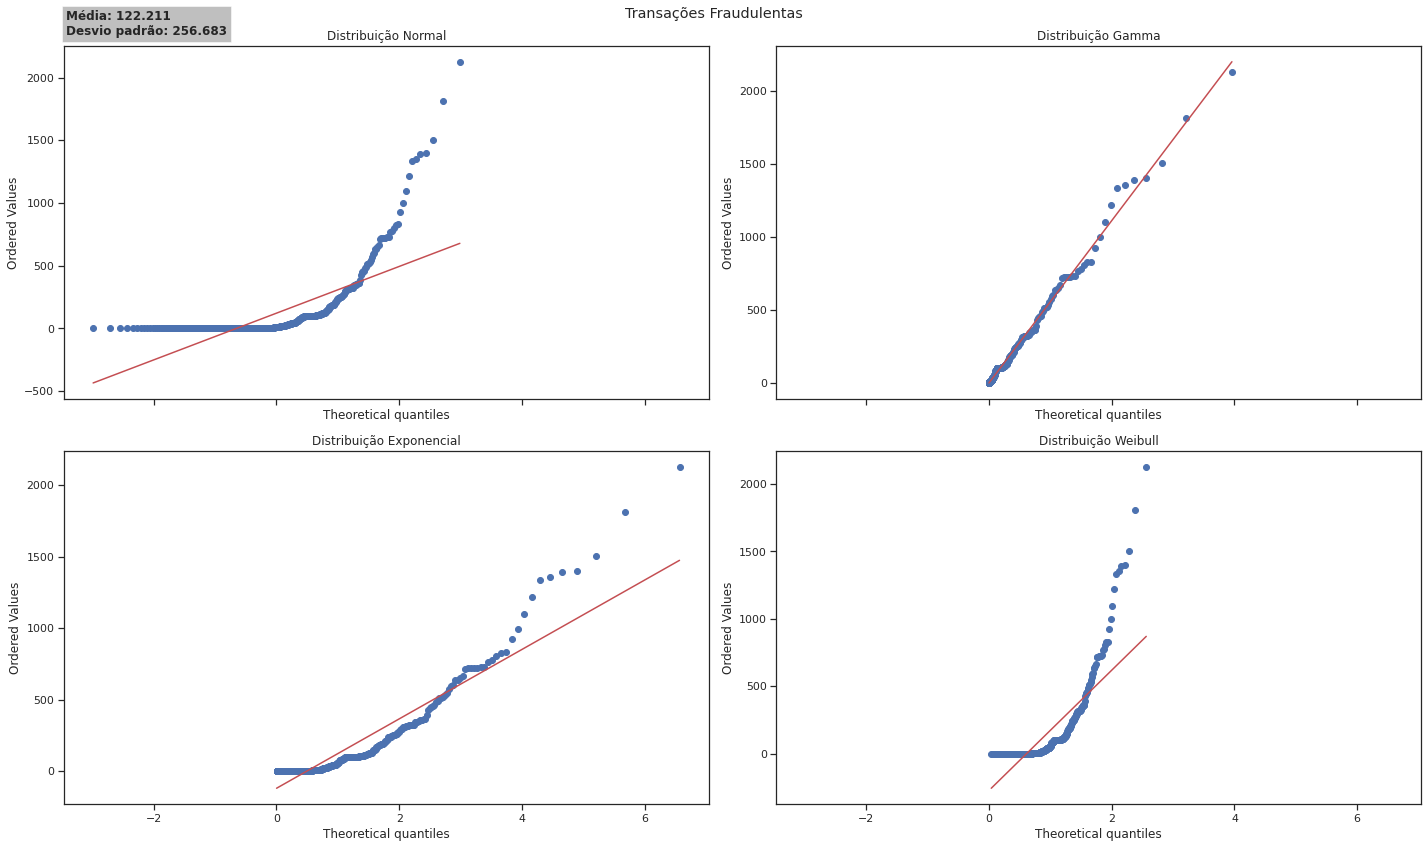

In [ ]:
# QQ-Plots Distribuições- Transações Fraudulentas

fig, ax = plt.subplots(2,2, sharex=True)
dict_dists = {'Normal':stats.norm, 'Gamma':stats.gamma, 'Exponencial':stats.expon, 'Weibull':stats.weibull_min}
list_sparams = [None, (df.loc[df['class']==1]['amount'].mean()**2 / df.loc[df['class']==1]['amount'].var()), None, (2)]
axes = ax.flatten()

for ax, distribution, sparam in zip(axes, dict_dists, list_sparams):
  
  stats.probplot(df.loc[df['class']==1]['amount'], dist=dict_dists[distribution], sparams=sparam, plot=ax)
  ax.set_title(f'Distribuição {distribution}')
  
fig.suptitle("Transações Fraudulentas")
fig.text(0.05, 0.96, f"Média: {df.loc[df['class']==1]['amount'].mean():.3f} \nDesvio padrão: {df.loc[df['class']==1]['amount'].std():.3f}", 
        va='center', ha="left", 
        fontdict=dict(weight='bold'),
        bbox=dict(facecolor="grey",alpha=0.5),
        transform=plt.gcf().transFigure);
fig.tight_layout()

*Nota:* pelos gráficos QQ-Plot acima, pode-se inferir que a distribuição dos gastos de transações **fraudulentas** aproxima-se mais de uma distribuição **Gamma**.



---

### Análise multivariada para entender a relação entre os gastos, time e classificação das transações

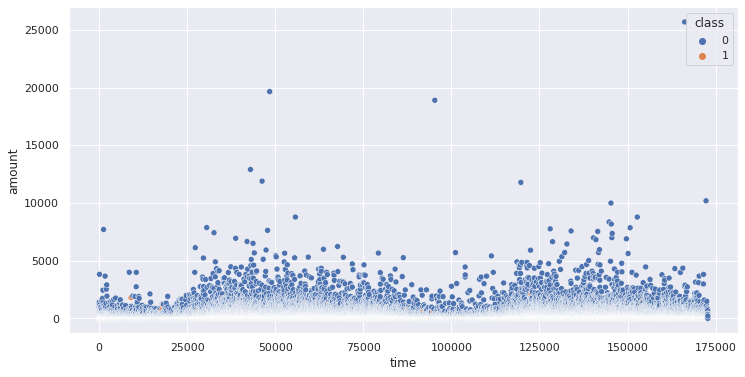

In [ ]:
# Análise multivariada para entender a relação entre os gastos, time e classificação das transações
sns.set(rc={'figure.figsize':(12,6)})
sns.scatterplot(x = 'time', y = 'amount', hue = 'class', data = df);



---


### Realize um teste A/B da seguinte forma: separe, aleatoriamente, dois grupos. O grupo A deve conter 50% das transações não fraudulentas e 50% das transações fraudulentas. O grupo B, por sua vez, deve conter os dados restantes. Por exemplo, se o dataset tivesse 100 transações (sendo 80 não fraudulentas e 20 fraudulentas), o grupo A teria 40 transações não fraudulentas e 10 transações fraudulentas (as mesmas quantidades se aplicariam ao grupo B). O grupo A deve ser o grupo de controle. O grupo B será o grupo que receberá a nova técnica de identificação de transações fraudulentas. Essa técnica consiste em: caso a transação possua um valor maior ou igual a 122.20, ela deve ser classificada como fraudulenta. Avalie o desempenho dessa nova técnica sobre a porcentagem de transações fraudulentas do grupo A. Qual a porcentagem das transações que realmente eram fraudulentas realmente foram classificadas como fraudulentas? A técnica aplicada no grupo B é melhor do que a do grupo A?;

In [17]:
df['class'].value_counts(dropna=False)

0    284315
1       492
Name: class, dtype: int64

In [18]:
group_a = pd.concat([df.loc[df['class']==1].sample(frac=0.5, random_state=42), df.loc[df['class']==0].sample(frac=0.5, random_state=42)])

In [19]:
# conferindo as proporções do grupo A
display(group_a['class'].value_counts())
print(format('','*^82'))
group_a['class'].value_counts() / df['class'].value_counts()

0    142158
1       246
Name: class, dtype: int64

**********************************************************************************


0   0.500
1   0.500
Name: class, dtype: float64

In [21]:
group_b = df.loc[~df.index.isin(group_a.index)].copy()

In [22]:
# conferindo as proporções do grupo B
display(group_b['class'].value_counts())
print(format('','*^82'))
group_b['class'].value_counts() / df['class'].value_counts()

0    142157
1       246
Name: class, dtype: int64

**********************************************************************************


0   0.500
1   0.500
Name: class, dtype: float64

In [23]:
group_a.reset_index(drop=True, inplace=True)
group_b.reset_index(drop=True, inplace=True)

In [24]:
#  O grupo B será o grupo que receberá a nova técnica de identificação de transações fraudulentas.

# armazenando as observacoes do grupo_b para comparação futura
df_b = group_b.copy()

# aplicando a nova técnica de identificação
group_b['class'] = group_b['amount'].apply(lambda x: 1 if x>=122.20 else 0)

In [25]:
# Avalie o desempenho dessa nova técnica sobre a porcentagem de transações fraudulentas do grupo A
df_comp = pd.concat([group_b['class'].value_counts(), group_a['class'].value_counts()], axis=1).reset_index()
df_comp.columns = ['classe','grupo_b', 'grupo_a']
df_comp

classe  grupo_b  grupo_a
0       0   118385   142158
1       1    24018      246

In [26]:
df_comp_plot = df_comp.melt(id_vars='classe', value_vars=['grupo_b', 'grupo_a'])
totais_grupo = df_comp_plot.groupby('variable')['value'].sum()
df_comp_plot['percentage'] = df_comp_plot[['variable','value']].apply(lambda x: (x['value'] / totais_grupo[x['variable']]) * 100, axis=1)
df_comp_plot

classe variable   value  percentage
0       0  grupo_b  118385      83.134
1       1  grupo_b   24018      16.866
2       0  grupo_a  142158      99.827
3       1  grupo_a     246       0.173

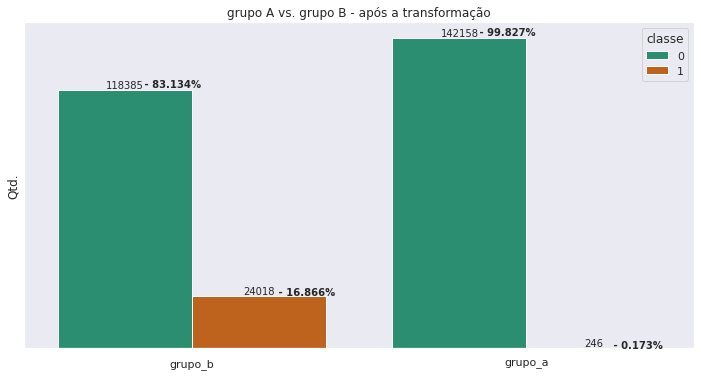

In [27]:
sns.set(rc={'figure.figsize':(12,6)})
ax = sns.barplot(data=df_comp_plot, x='variable', y='value', hue='classe', ci=False, palette='Dark2')
ax.set(title='grupo A vs. grupo B - após a transformação', xlabel=None, ylabel='Qtd.', yticks=[])
# valores sobre o gráfico
for container in ax.containers:
  ax.bar_label(container, fontsize=10, fmt = '%d')

for p in ax.patches:    
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()    
    plt.text(x+width/1.6,
             y+height*1.01,
             ' - '+str(round(df_comp_plot.loc[df_comp_plot['value']==height]['percentage'].squeeze(), 3))+'%',
             ha='left', 
             weight='bold',
             fontdict=dict(fontsize=10))


In [30]:
pct_fraude_b = df_comp.loc[df_comp['classe']==1,'grupo_b'].squeeze() / df_comp['grupo_b'].sum() * 100
pct_fraude_a = df_comp.loc[df_comp['classe']==1,'grupo_a'].squeeze() / df_comp['grupo_a'].sum() * 100
print(f'Após a aplicação da nova técnica, o grupo B (tratamento) passou a apresentar {round(pct_fraude_b, 3)}% de transações fraudulentas, \
\nenquanto que no grupo A (controle) temos {round(pct_fraude_a,3)}% de transações fraudulentas')

Após a aplicação da nova técnica, o grupo B (tratamento) passou a apresentar 16.866% de transações fraudulentas, 
enquanto que no grupo A (controle) temos 0.173% de transações fraudulentas


In [31]:
#  Qual a porcentagem das transações que realmente eram fraudulentas realmente foram classificadas como fraudulentas? 
realmente_fraudulentas =  df_b.loc[df_b['class']==1].index
pct_result = group_b.loc[(group_b.index.isin(realmente_fraudulentas)) & (group_b['class']==1)].shape[0] / len(realmente_fraudulentas) * 100

print(f'No grupo B, {round(pct_result,3)}% das transações que realmente eram fraudulentas foram classificadas como fraudulentas')

No grupo B, 21.951% das transações que realmente eram fraudulentas foram classificadas como fraudulentas


In [32]:
# A técnica aplicada no grupo B é melhor do que a do grupo A?
pct_result = group_b.loc[(group_b.index.isin(realmente_fraudulentas)) & (group_b['class']==1)].shape[0] / len(group_b.loc[group_b['class']==1]) * 100
print(f'Após a aplicação da nova técnica no grupo B, {round(pct_result,3)}% das transações classificadas como fraudulentas realmente eram fraudulentas, \
\nenquanto que no grupo A temos {round(pct_fraude_a,3)}% de transações fraudulentas.')
print('')

Após a aplicação da nova técnica no grupo B, 0.225% das transações classificadas como fraudulentas realmente eram fraudulentas, 
enquanto que no grupo A temos 0.173% de transações fraudulentas


In [ ]:
# A técnica aplicada no grupo B é melhor do que a do grupo A?

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Teste de hipótese
# H0: A técnica aplicada no grupo B não é melhor do que a do grupo A
# H1: A técnica aplicada no grupo B é melhor do que a do grupo A


control_results = group_a['class'] 
treatment_results = group_b['class'] 

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -159.56
p-value: 0.000
ci 95% for control group: [0.002, 0.002]
ci 95% for treatment group: [0.167, 0.171]


Como o `p-value = 0.000` é menor que o nível de significância `α=0.05`, podemos rejeitar H0. Assim, assumimos que **a técnica aplicada no grupo B é melhor que a do grupo A**.

### Realize o seguinte teste de hipótese: transações fraudulentas possuem valores de gasto, na média, maiores ou iguais a 122.20; 

In [ ]:
## Teste de hipótese
# H0:  transações fraudulentas possuem valores de gasto, na média, iguais a 122.20
# H1:  transações fraudulentas possuem valores de gasto, na média, diferentes de 122.20

sample_mean = df.loc[df['class']==1, 'amount'].mean()

print(f'Média da nossa amostra: {sample_mean}')
test_stat, p_value = stats.ttest_1samp(a=df.loc[df['class']==1, 'amount'], popmean=122.20, alternative='two-sided')
print('p-value: ', round(p_value, 4))
if p_value > 0.05:
  print('Não podemos rejeitar a Hipótese Nula (H0)')

Média da nossa amostra: 122.21131896972656
p-value:  0.9992
Não podemos rejeitar a Hipótese Nula (H0)


In [ ]:
## Teste de hipótese
# H0:  transações fraudulentas possuem valores de gasto, na média, maiores 122.20
# H1:  transações fraudulentas possuem valores de gasto, na média, menores que 122.20

sample_mean = df.loc[df['class']==1, 'amount'].mean()

print(f'Média da nossa amostra: {sample_mean}')
test_stat, p_value = stats.ttest_1samp(a=df.loc[df['class']==1, 'amount'], popmean=122.20, alternative='less')
print('p-value: ', round(p_value, 4))
if p_value > 0.05:
  print('Não podemos rejeitar a Hipótese Nula (H0)')

Média da nossa amostra: 122.21131896972656
p-value:  0.5004
Não podemos rejeitar a Hipótese Nula (H0)


Como o `p-value` foi maior que o nível de significância `α=0.05` nos dois testes, não podemos rejeitar Hο, o que significa que assumimos que transações fraudulentas possuem valores de gasto, na média, maiores ou iguais a 122.20 .

### Utilizando as classes LogisticRegression e SMOTE, realize oversampling e treine o modelo, relatando qual a porcentagem de transações fraudulentas detectadas.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df[['amount']]
y = df['class']

classifier = LogisticRegression(random_state=42)
classifier.fit(X, y)

print(f'Porcentagem de transações preditas como fraudulentas: {100*np.mean(classifier.predict(X) == 1)}%')

Porcentagem de transações preditas como fraudulentas: 0.0%


In [ ]:
# Aplicando a técnica de oversampling SMOTE para balancear o dataset
X_resampled, y_resampled = makeOverSamplesSMOTE(X, y)

In [ ]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_resampled, y_resampled)

print(f'Porcentagem de transações preditas como fraudulentas: {100*np.mean(classifier.predict(X_resampled) == 1)}%')

Porcentagem de transações preditas como fraudulentas: 22.750294567645042%
